# Double Pendulum

Simple simulation of a double pendulum using:
- Sympy: for the symbolic computation of the equations of motion
- Scipy: for the numerical integration of the equations of motion
- Matplotlib: for the visualization of the simulation

Using Lagrangian Mechanics:
- q_1 = angle of the first pendulum (theta_1)
- q_2 = angle of the second pendulum (theta_2)
- m_1 = mass of the first pendulum
- m_2 = mass of the second pendulum
- l_1 = length of the first pendulum
- l_2 = length of the second pendulum
- g = acceleration due to gravity

## Position of the pendulums

The position of the pendulums can be described by the following equations:
$$
r_1(\theta_1) = (l_1 \sin(\theta_1), -l_1 \cos(\theta_1))
$$
$$
r_2(\theta_1, \theta_2) = r_1(\theta_1) + (l_2 \sin(\theta_2), -l_2 \cos(\theta_2)) = (l_1 \sin(\theta_1) + l_2 \sin(\theta_2), -l_1 \cos(\theta_1) - l_2 \cos(\theta_2))
$$
$$
\begin{align*}
	r_1(\theta_1) &= (l_1 \sin(\theta_1), -l_1 \cos(\theta_1)) \\
	r_2(\theta_1, \theta_2) &= (l_1 \sin(\theta_1) + l_2 \sin(\theta_2), -l_1 \cos(\theta_1) - l_2 \cos(\theta_2))
\end{align*}
$$

The velocity $(dr/dt)$ is:
$$
\begin{align*}
	v_1 &= \frac{dr_1}{dt} = (l_1 \cos(\theta_1) \dot{\theta_1}, l_1 \sin(\theta_1) \dot{\theta_1}) \\
	v_2 &= \frac{dr_2}{dt} = (l_1 \cos(\theta_1) \dot{\theta_1} + l_2 \cos(\theta_2) \dot{\theta_2}, l_1 \sin(\theta_1) \dot{\theta_1} + l_2 \sin(\theta_2) \dot{\theta_2})
\end{align*}
$$

The Lagrangian of the system is given by:
$$
L = T - U
$$

Where:
- T = Kinetic energy of the system
- U = Potential energy of the system


In [20]:
import numpy as np
import matplotlib.pyplot as plt

import sympy as smp
from scipy.integrate import solve_ivp
from scipy.integrate import odeint

from pathlib import Path

In [19]:
gifs_dir = Path('gifs')
gifs_dir.mkdir(exist_ok=True)

In [2]:
# Define params as symbols
t, g = smp.symbols('t g')
m1, m2, l1, l2 = smp.symbols('m1 m2 l1 l2')

# Define generalized coordinates
th1, th2 = smp.symbols('theta_1 theta_2', cls=smp.Function)
th1 = th1(t)
th2 = th2(t)

# Define the derivatives and second derivatives
th1_d = smp.diff(th1, t)
th2_d = smp.diff(th2, t)
th1_dd = smp.diff(th1_d, t)
th2_dd = smp.diff(th2_d, t)

In [3]:
# Define position of both masses
r1 = smp.Matrix([l1*smp.sin(th1), -l1*smp.cos(th1)])
r2 = r1 + smp.Matrix([l2*smp.sin(th2), -l2*smp.cos(th2)])

# Define velocities of both masses
v1 = r1.diff(t)
v2 = r2.diff(t)

In [4]:
# Kinetic energy
T1 = 0.5*m1*v1.dot(v1)
T2 = 0.5*m2*v2.dot(v2)

T = (T1 + T2).simplify()

# Potential energy
V1 = m1*g*r1[1]
V2 = m2*g*r2[1]

V = (V1 + V2).simplify()

# Lagrangian
L = T - V

In [5]:
L

g*(l1*m1*cos(theta_1(t)) + l1*m2*cos(theta_1(t)) + l2*m2*cos(theta_2(t))) + 0.5*l1**2*m1*Derivative(theta_1(t), t)**2 + 0.5*m2*(l1**2*Derivative(theta_1(t), t)**2 + 2*l1*l2*cos(theta_1(t) - theta_2(t))*Derivative(theta_1(t), t)*Derivative(theta_2(t), t) + l2**2*Derivative(theta_2(t), t)**2)

Lagrange equations:

$$
\begin{align*}
	\frac{d}{dt} \left( \frac{\partial L}{\partial \dot{\theta}_1} \right) - \frac{\partial L}{\partial \theta_1} = 0\\
	\frac{d}{dt} \left( \frac{\partial L}{\partial \dot{\theta}_2} \right) - \frac{\partial L}{\partial \theta_2} = 0
\end{align*}
$$

In [6]:
LE1 = smp.diff(smp.diff(L, th1_d), t) - smp.diff(L, th1).simplify()
LE2 = smp.diff(smp.diff(L, th2_d), t) - smp.diff(L, th2).simplify()

In [7]:
solutions = smp.solve([LE1, LE2], [th1_dd, th2_dd])

I have something like this:

- $\frac{d^2\theta_1}{dt^2} = \ldots$
- $\frac{d^2\theta_2}{dt^2} = \ldots$


This is a system of second order differential equations, to use scipy to solve this system, we need to convert it to a system of first order differential equations.

For a 2nd order differential equation this is always possible using a variable substitution. Let's define:

- $\omega_1 = \frac{d\theta_1}{dt}$
- $\omega_2 = \frac{d\theta_2}{dt}$


Then we have:

- $\frac{d^2\theta_1}{dt^2} = \frac{d\omega_1}{dt}$
- $\frac{d^2\theta_2}{dt^2} = \frac{d\omega_2}{dt}$


The system of first order differential equations is:
$$
\begin{align*}
	\frac{d\theta_1}{dt} &= \omega_1 \\
	\frac{d\theta_2}{dt} &= \omega_2 \\
	\frac{d\omega_1}{dt} &= \ldots \\
	\frac{d\omega_2}{dt} &= \ldots
\end{align*}
$$

Converting this symbolic equations to numerical functions using lambdify, we can use scipy to solve the system of differential equations.

In [8]:
dw1_dt_func = smp.lambdify((th1, th2, th1_d, th2_d, m1, m2, l1, l2, g), solutions[th1_dd])
dw2_dt_func = smp.lambdify((th1, th2, th1_d, th2_d, m1, m2, l1, l2, g), solutions[th2_dd])
dth1_dt_func = smp.lambdify(th1_d, th1_d)
dth2_dt_func = smp.lambdify(th2_d, th2_d)

Define the state vector:
- $\vec{S} = [\theta_1, \theta_2, \omega_1, \omega_2]$

In [9]:
def dSdt(S, t, m1, m2, l1, l2, g):
	th1, th2, w1, w2 = S
	return [dth1_dt_func(w1),
			dth2_dt_func(w2),
			dw1_dt_func(th1, th2, w1, w2, m1, m2, l1, l2, g),
			dw2_dt_func(th1, th2, w1, w2, m1, m2, l1, l2, g)]

In [10]:
# Define the parameters
m1, m2 = 1, 2
l1, l2 = 1, 2
g = 9.81

t = np.linspace(0, 40, 1001)
S0 = [np.pi/4, np.pi/3, 0, 0]

In [21]:
sol = odeint(dSdt, S0, t, args=(m1, m2, l1, l2, g))

In [22]:
sol.T.shape
# By cols: theta1, theta2, w1, w2

(4, 1001)

In [23]:
th1 = sol.T[0]
th2 = sol.T[1]

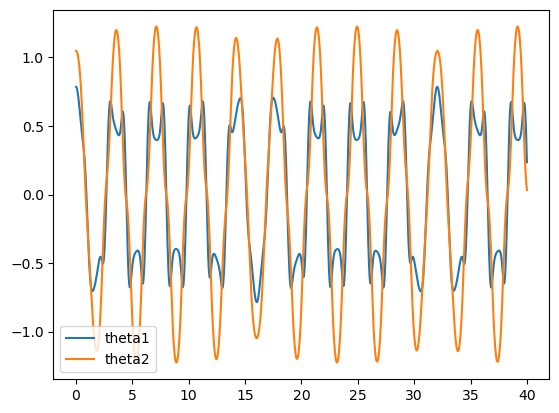

In [24]:
# Quick plot
plt.plot(t, th1, label='theta1')
plt.plot(t, th2, label='theta2')
plt.legend()

In [25]:
# Define the position of the masses from the angles

def get_positions(t, l1, l2, th1, th2):
	
	return (
		(l1*np.sin(th1), -l1*np.cos(th1)),
		(l1*np.sin(th1) + l2*np.sin(th2), -l1*np.cos(th1) - l2*np.cos(th2))
	)

r1, r2 = get_positions(t, l1, l2, th1, th2)
x1, y1 = r1
x2, y2 = r2

In [26]:
from matplotlib import animation
from matplotlib.animation import PillowWriter
from matplotlib.animation import FuncAnimation

def do_animation():
	def init():
		ln1.set_data([], [])
		return ln1,

	def animate(i):
		ln1.set_data([0, x1[i], x2[i]], [0, y1[i], y2[i]])
		return ln1,

	fig, ax = plt.subplots(1,1, figsize=(8,8))
	ax.set_facecolor('white')
	ln1, = plt.plot([], [], 'ko--', lw=3, markersize=8)
	ax.set_ylim(-(l1+l2+1), l1+l2+1)
	ax.set_xlim(-(l1+l2+1), l1+l2+1)
	ax.set_aspect('equal')

	ax.set_xlabel('x', fontsize=16)
	ax.set_ylabel('y', fontsize=16)

	ax.set_title('Double Pendulum', fontsize=20)
	ax.grid()

	ani = FuncAnimation(fig, animate, frames=1000, interval=50, blit=True, init_func=init)

	return ani

In [27]:
fps = int((len(t)-1)/(t[-1]-t[0]))

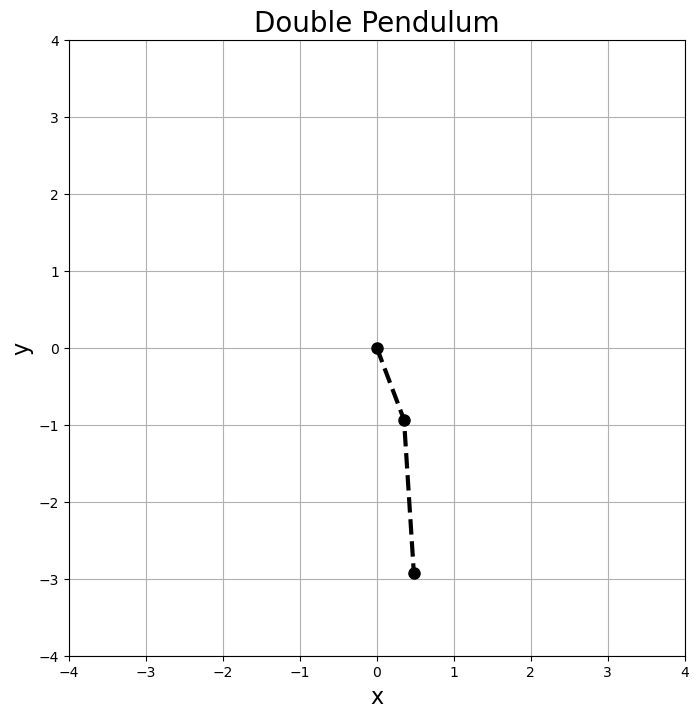

In [29]:
# The fps variable calculated from the time vector
fps = int((len(t) - 1) / t[-1])

ani = do_animation()
ani.save(gifs_dir / 'double_pendulum_1.gif', fps=fps, dpi=80, writer='pillow')

In [16]:
# Another simulation
t = np.linspace(0, 40, 1001)
S0 = [-4, 3, -1, 1]

m1, m2 = 1, 2
l1, l2 = 1, 2
g = 9.81

sol = odeint(dSdt, S0, t, args=(m1, m2, l1, l2, g))

In [30]:
th1 = sol.T[0]
th2 = sol.T[1]

r1, r2 = get_positions(t, l1, l2, th1, th2)
x1, y1 = r1
x2, y2 = r2

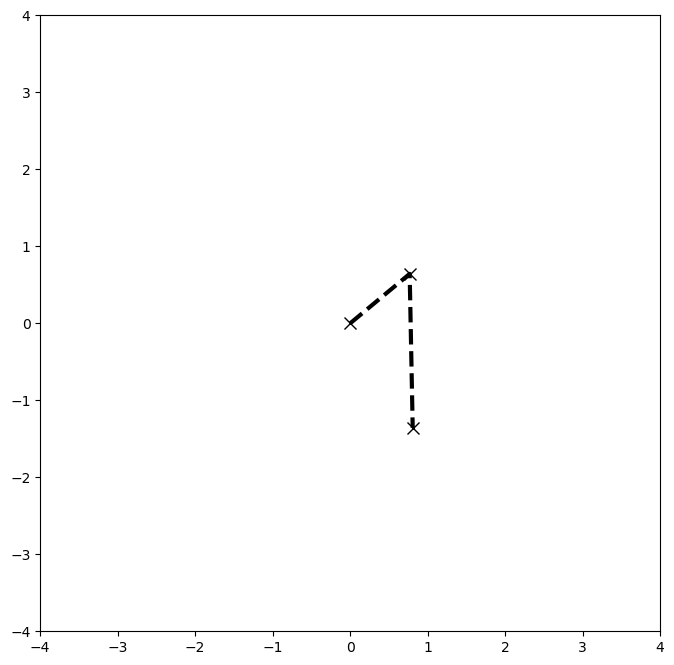

In [21]:
ani = do_animation()
ani.save(gifs_dir / '2_pendulum.gif', writer='pillow', fps=fps)

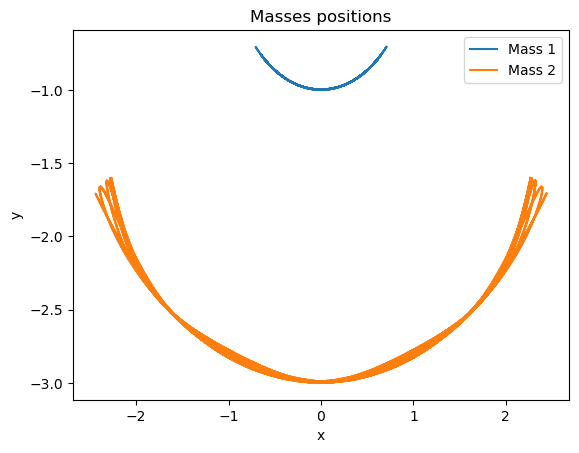

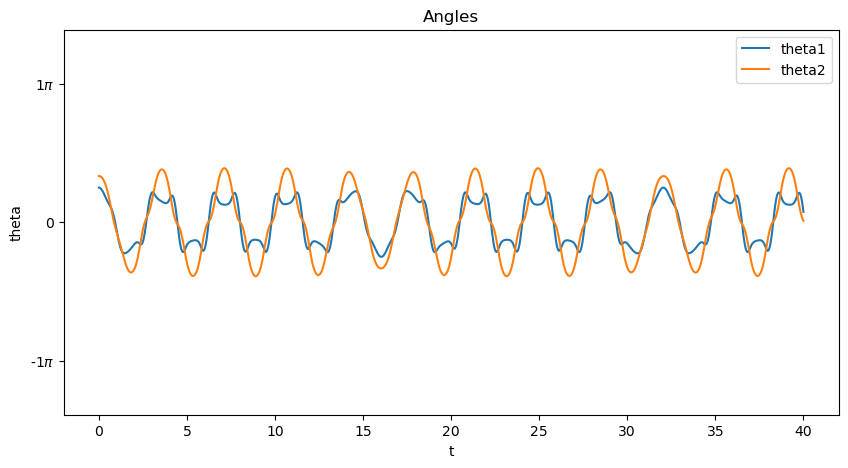

In [35]:
from matplotlib.ticker import MultipleLocator, FuncFormatter
# Plot the masses positions
def plot_masses(t, l1, l2, th1, th2):
	r1, r2 = get_positions(t, l1, l2, th1, th2)
	x1, y1 = r1
	x2, y2 = r2

	plt.plot(x1, y1, label='Mass 1')
	plt.plot(x2, y2, label='Mass 2')
	plt.title('Masses positions')
	plt.xlabel('x')
	plt.ylabel('y')
	plt.legend()
	plt.show()

def plot_angles(t, th1, th2, num_ticks=7):

	th_max = max([th1.max(), th2.max()])
	th_min = min([th1.min(), th2.min()])
	abs_max = max(abs(th_max), abs(th_min))

	fig, ax = plt.subplots(1, 1, figsize=(10, 5))
	ax.plot(t, th1, label='theta1')
	ax.plot(t, th2, label='theta2')

	ax.set_title('Angles')
	ax.set_xlabel('t')
	ax.set_ylabel('theta')

	# Set the y-axis ticks as multiples of pi
	tick_interval = (th_max - th_min) / (num_ticks - 1)

	# Set 'distance' between ticks
	if round(tick_interval/np.pi) < 1:
		tick_interval = np.pi
	else:
		tick_interval = np.pi * round(tick_interval / np.pi)

	ax.set_ylim(-(abs_max+np.pi), abs_max+np.pi)
	ax.yaxis.set_major_locator(MultipleLocator(base=tick_interval))
	ax.yaxis.set_major_formatter(FuncFormatter(lambda val, pos: '{:.0f}$\\pi$'.format(val / np.pi) if val != 0 else '0'))

	ax.legend()
	plt.show()

plot_masses(t, l1, l2, th1, th2)
plot_angles(t, th1, th2, num_ticks=9)

## Non Chaotic Solutions

In [28]:
# Try to find non-chaotic solutions

# Params
m1, m2 = 1, 1
l1, l2 = 1, 1
g = 9.81

# Initial conditions
S0 = [np.pi/4, -np.pi/4, 0, 0]

# Time vector
t = np.linspace(0, 40, 1001)

# Solve the system of equations
sol = odeint(dSdt, S0, t, args=(m1, m2, l1, l2, g))

In [29]:
# Plot
th1 = sol.T[0]
th2 = sol.T[1]

r1, r2 = get_positions(t, l1, l2, th1, th2)
x1, y1 = r1
x2, y2 = r2

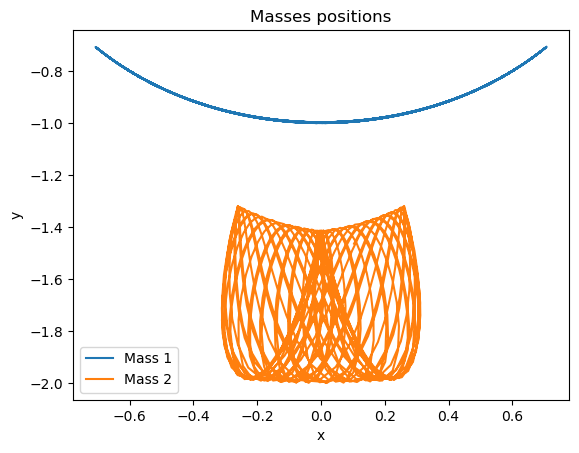

ValueError: 'step' must be positive

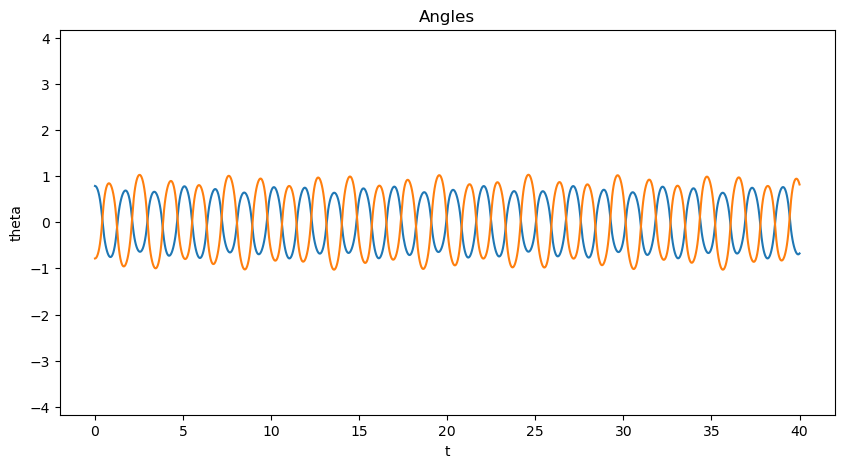

In [30]:
plot_masses(t, l1, l2, th1, th2)
plot_angles(t, th1, th2, num_ticks=9)

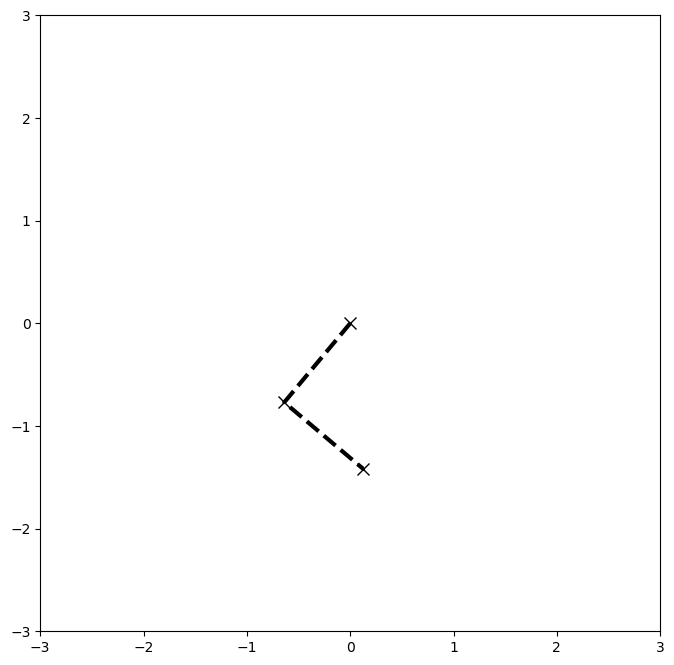

In [35]:
ani = do_animation()
ani.save(gifs_dir / '2_pendulum_non_chaos.gif', writer='pillow', fps=fps)